In [1]:
import os
import glob

In [2]:
delhi_hchos = glob.glob('HCHO_tifs/delhi*.tif')

In [3]:
len(delhi_hchos)

120

In [4]:
delhi_no2s = glob.glob('NO2_tifs/delhi*.tif')

In [5]:
len(delhi_no2s)

120

In [6]:
delhi_hchos

['HCHO_tifs\\delhi_15dayavg_hcho_2019-01-01.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tifs\\delhi_15dayavg_hcho_2019-01-16.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tifs\\delhi_15dayavg_hcho_2019-02-01.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tifs\\delhi_15dayavg_hcho_2019-02-16.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tifs\\delhi_15dayavg_hcho_2019-03-01.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tifs\\delhi_15dayavg_hcho_2019-03-16.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tifs\\delhi_15dayavg_hcho_2019-04-01.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tifs\\delhi_15dayavg_hcho_2019-04-16.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tifs\\delhi_15dayavg_hcho_2019-05-01.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tifs\\delhi_15dayavg_hcho_2019-05-16.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tifs\\delhi_15dayavg_hcho_2019-06-01.tropospheric_HCHO_column_number_density.tif',
 'HCHO_tif

In [7]:
delhi_no2s

['NO2_tifs\\delhi_15dayavg_no2_2019-01-01.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-01-16.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-02-01.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-02-16.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-03-01.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-03-16.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-04-01.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-04-16.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-05-01.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-05-16.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-06-01.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-06-16.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-07-01.NO2_column_number_density.tif',
 'NO2_tifs\\delhi_15dayavg_no2_2019-07

In [22]:
# Convert tiff to aray
import numpy as np
import rasterio

def tiff_to_array_rasterio(file_path):
    # Open the TIFF file
    with rasterio.open(file_path) as src:
        # Read the image data
        img_array = src.read()
        # Optionally, you may want to read metadata
        meta = src.meta
        xmin, ymin, xmax, ymax = src.bounds

    
    return img_array, meta, xmin, ymin, xmax, ymax


In [97]:
delhi_hchos[8+24]

'HCHO_tifs\\delhi_15dayavg_hcho_2020-05-01.tropospheric_HCHO_column_number_density.tif'

In [98]:
num = 8+24
hcho_array, meta, xmin, ymin, xmax, ymax = tiff_to_array_rasterio(delhi_hchos[num])
# Replace negative values with zero
hcho_array[hcho_array < 0] = 0

no2_array, meta, xmin, ymin, xmax, ymax = tiff_to_array_rasterio(delhi_no2s[num])

In [99]:
fnr = hcho_array/no2_array

In [100]:
# Convert tif into grids shapefile
import geopandas as gpd
from shapely.geometry import box

idx, rows, cols = fnr.shape
x_res = (xmax - xmin) / cols
y_res = (ymax - ymin) / rows

# Create polygons from the grid cells
polygons = []
for i in range(rows):
    for j in range(cols):
        x = xmin + j * x_res
        y = ymax - (i + 1) * y_res
        polygons.append({
            'geometry': box(x, y, x + x_res, y - y_res),
            'value': fnr[0, i, j]  # Assuming the raster has values associated with each cell
        })
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(polygons)

# Assign CRS to the GeoDataFrame
gdf.crs = 'EPSG:4326'


In [101]:
# Define custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 'blue'), (0.25, 'green'), (0.45, 'yellow'), (0.7, 'brown'), (1, 'white')]  # Define color points: (position, color)
cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

In [102]:
print('{}-{}'.format(fnr.min(),fnr.max()))

1.0244202571898033-4.570489582147804


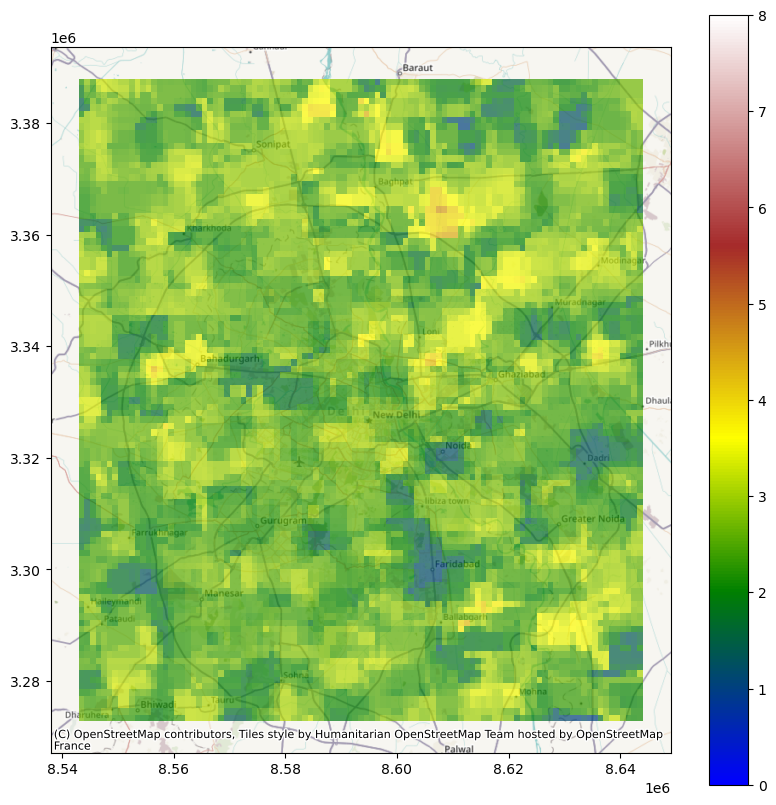

In [103]:
import matplotlib.pyplot as plt
import contextily as cx

## Plot grids_masked for the masked map
gdf_wm = gdf.to_crs(epsg=3857)
ax = gdf_wm.plot(figsize=(10, 10),
              column='value',
              alpha=0.7, #Transparency
              legend=True,
              cmap=custom_cmap,
              vmin=0,
              vmax=8
             )
cx.add_basemap(ax)

plt.show()

In [81]:
# Write the array to a TIFF file
with rasterio.open('fnr_2019winter.tif', 'w', **meta) as dst:
    dst.write(fnr)

In [69]:
meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 101,
 'height': 101,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.008983152841195215, 0.0, 76.74307472233072,
        0.0, -0.008983152841195215, 29.105415205472497)}

In [70]:
fnr.max()

5.497915706083308

In [78]:
delhi_hchos[22]

'HCHO_tifs\\delhi_15dayavg_hcho_2019-12-01.tropospheric_HCHO_column_number_density.tif'